## Evolution of Interdisciplinary Concepts Using Research Methodologies

##### Import Libraries

In [2]:
from neo4j import GraphDatabase
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
import requests
from neo4j import graph
import csv
import requests
from requests.exceptions import ConnectionError
import time
from collections import deque
import networkx as nx
from networkx_viewer import Viewer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

##### Connect to Neo4j

In [ ]:
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

with GraphDatabase.driver(URI, auth=AUTH) as driver: 
    driver.verify_connectivity() 

##### Retry if Connection Issues Arise to Retrieve Response

In [5]:
def make_request_with_retries(url, max_retries=5):
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response
        except ConnectionError as e:
            retries += 1
            wait_time = 2 ** retries
            print(f"Connection aborted. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            break
    return None

##### Open URL To Get Related Concepts Response

In [6]:
def get_response(url):
    url = url
    response = make_request_with_retries(url)
    if response.status_code == 200:
        related_concepts = response.json()
        return related_concepts
    else:
        print(f"Failed to retrieve related concepts: {response.status_code}")
        return None

##### Extracting Related Concepts From Response

In [7]:
def get_related_concepts(data_dict):
    related_concepts = []
    related_concepts_list = data_dict.get('related_concepts', [])
    
    for entry in related_concepts_list:
        id_value = entry.get('id', None)
        display_name_value = entry.get('display_name', None)
        score_value = entry.get('score', None)
        
        if True:
            modified_id_value = id_value.replace('https://openalex.org/', 'https://api.openalex.org/concepts/') if id_value else None
            
            related_concepts.append({
                'id': modified_id_value,
                'display_name': display_name_value,
                'score': score_value
            })      
    return related_concepts

##### Extracting URLS From IDs of Related Concepts

In [8]:
def extract_urls(data):
    extracted_urls = []
    
    if isinstance(data, list):
        for entry in data:
            id_value = entry.get('id', None)
            if id_value:
                extracted_urls.append(id_value)
    
    elif isinstance(data, dict):
        id_value = data.get('id', None)
        if id_value:
            extracted_urls.append(id_value)
            
    return extracted_urls

##### Get Citation Count For Concept

In [9]:
def get_citation_count(url):
    
    url = url+'?select=cited_by_count'
    response = requests.get(url)
    if response.status_code == 200:
        related_concepts = response.json()
    cited_by_count_value = related_concepts.get('cited_by_count', None)
    
    return cited_by_count_value

##### Properties For Node

In [10]:
def node_properties(dictdd):
    extraction = extract_urls(dictdd)
    citation_count = (get_citation_count(extraction[0]))
    dictdd['cited_by_count'] = citation_count
    return dictdd

##### Defining Start URL

In [16]:
starting_url = 'https://api.openalex.org/concepts/C41008148'

##### Get Name from URL

In [17]:
def get_display_name_from_url(url):
    url = url+'?select=display_name'
    response = requests.get(url)
    return response.json()['display_name']

##### Create Node in Graph in Neo4j

In [19]:
def create_node(name, id, paper_count):
    def create_person(tx, name, id, paper_count):
        query = (
            "CREATE (p:Concept {name: $name, id: $id, paper_count: $paper_count})"
        )
        tx.run(query, name=name, id=id, paper_count=paper_count)

    with driver.session(database="graph2020") as session:
        session.execute_write(create_person, name, id, paper_count)


##### Creating Relationship Between Two Nodes in Neo4j

In [20]:
def create_relationship(name1, name2, weight):    
    def create_weighted_relationship(tx, name1, name2, weight):
        query = (
            f"MATCH (a:Concept {{id: '{name1}'}}), (b:Concept {{id: '{name2}'}})"
            f"CREATE (a)-[r:RELATED_TO {{weight: {weight}}}]->(b)"
            "RETURN r"
        )
        return tx.run(query)

    with driver.session(database="graph2020") as session:
        session.execute_write(create_weighted_relationship, name1, name2, weight)

##### Check if node is present or not in Neo4j

In [21]:
def check_node_exists( label, property_name, property_value):
    query = f"MATCH (n:{label} {{ {property_name}: '{property_value}' }}) RETURN COUNT(n) > 0 AS nodeExists"
    result = driver.session(database="graph2020").run(query)
    return result.single()["nodeExists"]

##### Create Node in Graph Using NetworkX

In [22]:
def create_node_nx(graph, url, name):
    graph.add_node(url, name=name)

##### Create Relationship Using NetworkX

In [23]:
def create_edge_nx(graph, url1, url2, weight):
    node1 = None
    node2 = None
    for node, attrs in graph.nodes(data=True):
        if node == url1:
            node1 = node
        elif node == url2:
            node2 = node
    if node1 is not None and node2 is not None:
        graph.add_edge(node1, node2, weight=weight)

##### Neo4j DB Connection

In [25]:
def create_db_connection(uri, user, password):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    return driver
def run_query(driver, database_name, query):
    with driver.session(database="graph2020") as session:
        result = session.run(query)
        return [record for record in result]
uri = "neo4j://localhost:7687"  
username = "neo4j"     
password = "password"     

db_driver = create_db_connection(uri, username, password)

##### Get Response from URL

In [26]:
def get_count_from_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            json_data = response.json()
            return json_data.get('meta', {}).get('count')
        else:
            print(f"Failed to retrieve data: {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"HTTP Request failed: {e}")
        return None

##### Sub Time Graph Yearwise

In [28]:
from collections import deque

def bfs_with_year(driver, start_url, year):
    visited = set()
    queue = deque()
    concept_to_url = {}
    existing_relationships = set()
    node_count = 0

    def add_relationship(node1, node2, score):
        if (node1, node2) not in existing_relationships and (node2, node1) not in existing_relationships:
            create_relationship(node1, node2, score)
            existing_relationships.add((node1, node2))

    def find_paper_count(counts_by_year, year):
        for count in counts_by_year:
            if count['year'] == year:
                return count['works_count']
        return 0

    initial_concepts_data = get_response(start_url)
    initial_related_concepts = get_related_concepts(initial_concepts_data)
    initial_paper_count = find_paper_count(initial_concepts_data.get('counts_by_year', []), int(year))

    if not check_node_exists("Concept", "id", start_url):
        if node_count < 1000:
            create_node(initial_concepts_data["display_name"], start_url, initial_paper_count)
            node_count += 1

    for concept in initial_related_concepts:
        concept_url = concept.get('id')
        concept_name = concept.get('display_name')
        concept_data = get_response(concept_url)
        concept_paper_count = find_paper_count(concept_data.get('counts_by_year', []), int(year))

        if concept_url and concept_name:
            if not check_node_exists("Concept", "id", concept_url):
                if node_count < 1000:
                    create_node(concept_name, concept_url, concept_paper_count)
                    node_count += 1
            add_relationship(start_url, concept_url, get_count_from_url("https://api.openalex.org/works?filter=publication_year:"+year+",concepts.id:"+start_url.split('/')[-1]+"+"+concept_url.split('/')[-1]))
            queue.append(concept_url)
            concept_to_url[concept_url] = start_url

    while queue:
        current_url = queue.popleft()

        if current_url not in visited:
            visited.add(current_url)

            related_concepts_data = get_response(current_url)
            related_concepts = get_related_concepts(related_concepts_data)

            for concept in related_concepts:
                concept_url = concept.get('id')
                concept_name = concept.get('display_name')
                concept_data = get_response(concept_url)
                concept_paper_count = find_paper_count(concept_data.get('counts_by_year', []), int(year))

                if concept_url and concept_name:
                    if concept_url not in concept_to_url:
                        if not check_node_exists("Concept", "id", concept_url):
                            if node_count < 1000:
                                create_node(concept_name, concept_url, concept_paper_count)
                                node_count += 1
                        concept_to_url[concept_url] = current_url
                        queue.append(concept_url)
                    add_relationship(current_url, concept_url, get_count_from_url("https://api.openalex.org/works?filter=publication_year:"+year+",concepts.id:"+start_url.split('/')[-1]+"+"+concept_url.split('/')[-1]))



In [ ]:
bfs_with_year(driver,starting_url, "2020")

### Graph Analytics 

In [38]:
starting_year= 2020

In [39]:
def fetch_data_for_one_year(start_year):
    all_data = []

    
    with driver.session(database=f"graph{start_year}") as session:
        query = """
        MATCH (a:Concept)-[r:RELATED_TO]->(b:Concept)
        RETURN a.name AS ConceptA,a.paper_count as CountA, b.name AS ConceptB,b.paper_count as CountB, r.weight AS TotalCount
        """
        results = session.run(query).values()
            
        for row in results:
            all_data.append({
                "Year": start_year,
                "ConceptA": row[0],
                "CountA": row[1],
                "ConceptB": row[2],
                "CountB": row[3],
                "TotalCount": row[4]
            })

    df = pd.DataFrame(all_data)
    return df

In [40]:
data=fetch_data_for_one_year(starting_year)

C:\Users\kotla\AppData\Local\Temp\ipykernel_19348\2307828354.py:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=f"graph{start_year}") as session:


In [10]:
#data to csv
data.to_csv(f'timeseries_data_{starting_year}.csv', index=False)

In [32]:
def fetch_test(start_year):
    all_data = []

    
    with driver.session(database=f"graph{start_year}") as session:
        query = """
        MATCH (a:Concept)-[r:RELATED_TO]->(b:Concept)
        RETURN a.name AS ConceptA,a.id AS LinkA,a.paper_count as CountA, b.name AS ConceptB,b.id AS LinkB,b.paper_count as CountB, r.weight AS TotalCount
        """
        results = session.run(query).values()
            
        for row in results:
            all_data.append({
                "Year": start_year,
                "ConceptA": row[0],
                "LinkA": row[1],
                "CountA": row[2],
                "ConceptB": row[3],
                "LinkB": row[4],
                "CountB": row[5],
                "TotalCount": row[6]
            })

    df = pd.DataFrame(all_data)
    df.to_csv(f'testdata_{start_year}.csv', index=False)

In [40]:
fetch_test(2021)

C:\Users\kotla\AppData\Local\Temp\ipykernel_6900\4285128773.py:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session(database=f"graph{start_year}") as session:


##### Drag Data from Neo4j into DataFrame

In [ ]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "password"))

def fetch_data_for_all_years(start_year, end_year):
    all_data = []

    for year in range(start_year, end_year + 1):
        with driver.session(database=f"graph{year}") as session:
            query = """
            MATCH (a:Concept)-[r:RELATED_TO]->(b:Concept)
            RETURN a.name AS ConceptA, b.name AS ConceptB, r.weight AS TotalCount
            """
            results = session.run(query).values()
            
            for row in results:
                all_data.append({
                    "Year": year,
                    "ConceptA": row[0],
                    "ConceptB": row[1],
                    "TotalCount": row[2]
                })

    df = pd.DataFrame(all_data)
    return df

##### Fetching data from 2013 to 2023

In [3]:
file_paths = {
    '2013': 'timeseries_data_2013.csv',
    '2014': 'timeseries_data_2014.csv',
    '2015': 'timeseries_data_2015.csv',
    '2016': 'timeseries_data_2016.csv',
    '2017': 'timeseries_data_2017.csv',
    '2018': 'timeseries_data_2018.csv',
    '2019': 'timeseries_data_2019.csv',
    '2020': 'timeseries_data_2020.csv',
    '2021': 'timeseries_data_2021.csv',
    '2022': 'timeseries_data_2022.csv',
    '2023': 'timeseries_data_2023.csv',
}

combined_df = pd.concat([pd.read_csv(filepath) for filepath in file_paths.values()])

combined_df.to_csv('combined_timeseries_data.csv', index=False)

##### Sort the dataframe by totalcount


In [4]:
df = combined_df.sort_values(by='TotalCount', ascending=False)
df.head()

,Year,ConceptA,CountA,ConceptB,CountB,TotalCount
15,2023,Computer science,2931032,Artificial intelligence,895691,911764
16,2023,Mathematics,1229776,Artificial intelligence,895691,911764
16,2021,Mathematics,1259148,Artificial intelligence,853348,854320
15,2021,Computer science,3181368,Artificial intelligence,853348,854320
16,2022,Mathematics,1175235,Artificial intelligence,825176,825181


##### Saving dataframe as CSV

##### Calculating Year over Year Growth for all Concepts over all Years from 2013 to 2023

In [5]:
data = df
data['Year'] = pd.to_numeric(data['Year'])
data.sort_values(['ConceptA', 'ConceptB', 'Year'], inplace=True)

data['YoYGrowth'] = data.groupby(['ConceptA', 'ConceptB'])['TotalCount'].pct_change() * 100

data.head()

,Year,ConceptA,CountA,ConceptB,CountB,TotalCount,YoYGrowth
586,2017,Accounting,64760,Actuarial science,23926,8665,NaN
572,2018,Accounting,67543,Actuarial science,23421,8668,0.034622
2213,2017,Accounting,64760,Audit,14717,4367,NaN
2147,2018,Accounting,67543,Audit,15560,4713,7.923059
763,2017,Accounting,64760,Business,838670,336651,NaN


##### YoY Growth

In [6]:
data

,Year,ConceptA,CountA,ConceptB,CountB,TotalCount,YoYGrowth
586,2017,Accounting,64760,Actuarial science,23926,8665,NaN
572,2018,Accounting,67543,Actuarial science,23421,8668,0.034622
2213,2017,Accounting,64760,Audit,14717,4367,NaN
2147,2018,Accounting,67543,Audit,15560,4713,7.923059
763,2017,Accounting,64760,Business,838670,336651,NaN
...,...,...,...,...,...,...,...
1565,2019,Theoretical computer science,43426,Variety (cybernetics),21842,20611,0.654393
1659,2020,Theoretical computer science,47627,Variety (cybernetics),24877,23650,14.744554
1555,2021,Theoretical computer science,53791,Variety (cybernetics),24757,23477,-0.731501
1521,2022,Theoretical computer science,51103,Variety (cybernetics),23684,22386,-4.647101


##### Gathering Paper Count for 2 particular concepts over all years

In [7]:
df_actual = pd.read_csv('combined_timeseries_data.csv')

df_actual['ConceptA'] = df_actual['ConceptA'].str.lower()
df_actual['ConceptB'] = df_actual['ConceptB'].str.lower()

filtered_df_actual = df_actual[
    (df_actual['ConceptA'] == 'computer science') | 
    (df_actual['ConceptB'] == 'computer science') |
    (df_actual['ConceptA'] == 'artificial intelligence') | 
    (df_actual['ConceptB'] == 'artificial intelligence')
]

combined_df_actual = filtered_df_actual.groupby('Year')['TotalCount'].sum().reset_index()

combined_df_actual

,Year,TotalCount
0,2013,10567346
1,2014,10638825
2,2015,10784946
3,2016,10715365
4,2017,10978895
5,2018,11897446
6,2019,12662579
7,2020,13728073
8,2021,13948232
9,2022,13221395


##### Above data as a histogram

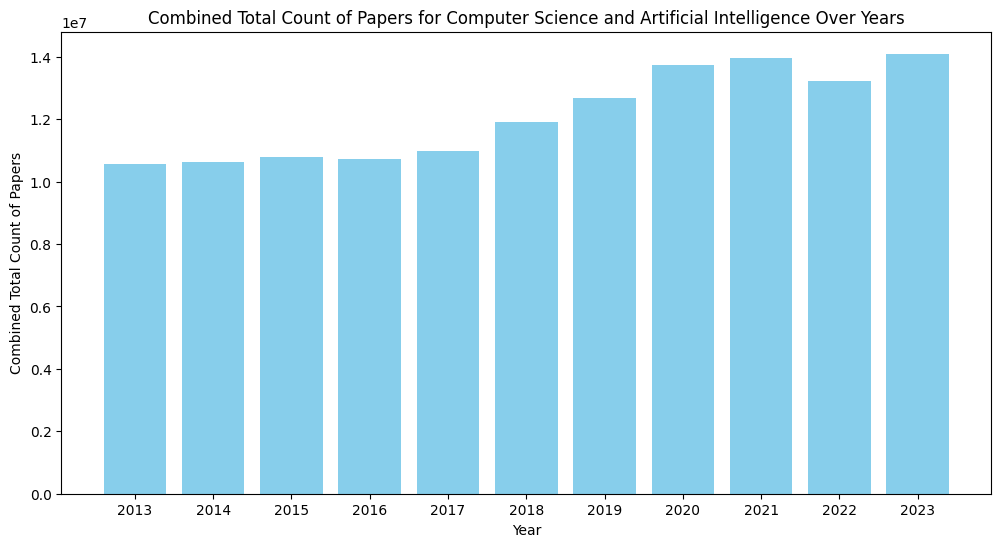

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(combined_df_actual['Year'], combined_df_actual['TotalCount'], color='skyblue')

plt.xlabel('Year')
plt.ylabel('Combined Total Count of Papers')
plt.title('Combined Total Count of Papers for Computer Science and Artificial Intelligence Over Years')
plt.xticks(combined_df_actual['Year']) 

plt.show()

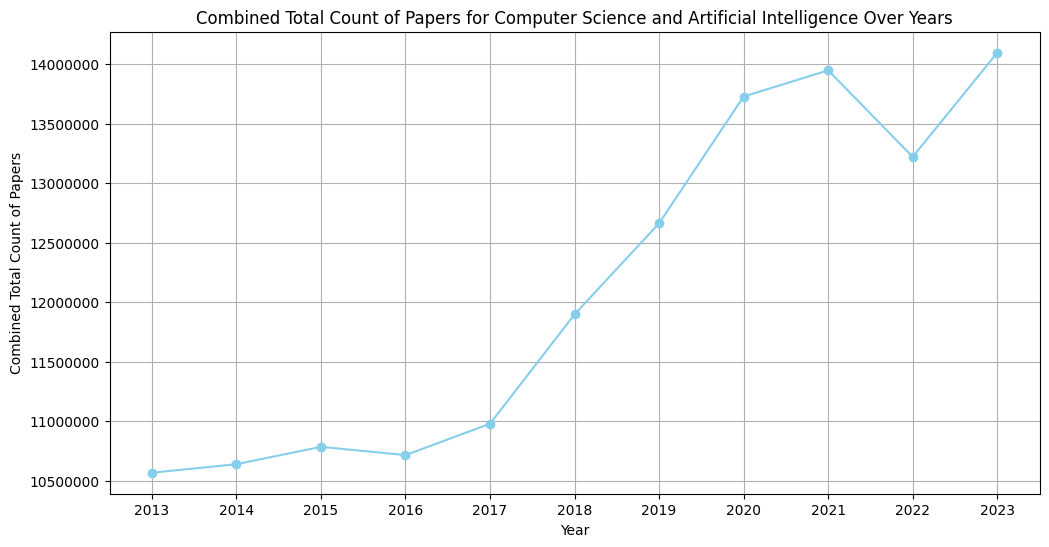

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define a formatter function
def large_number_formatter(x, pos):
    return '%1.0f' % x  # No decimal places, full number

plt.figure(figsize=(12, 6))
plt.plot(combined_df_actual['Year'], combined_df_actual['TotalCount'], marker='o', linestyle='-', color='skyblue')

plt.xlabel('Year')
plt.ylabel('Combined Total Count of Papers')
plt.title('Combined Total Count of Papers for Computer Science and Artificial Intelligence Over Years')
plt.xticks(combined_df_actual['Year'])

# Apply the custom formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(large_number_formatter))

plt.grid(True)  # Adding grid for better readability

plt.show()


##### YoY Growth As a Plot

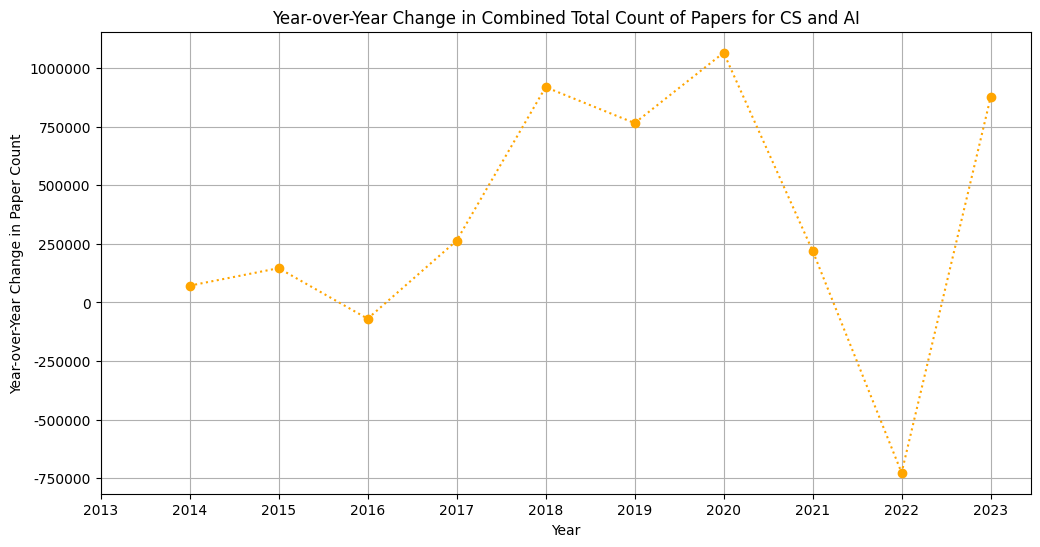

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis ticks as full numbers
def millions_formatter(x, pos):
    return '%1.0f' % x

plt.figure(figsize=(12, 6))
plt.plot(combined_df_actual['Year'], combined_df_actual['YoY_Change'], marker='o', linestyle=':', color='orange')

plt.xlabel('Year')
plt.ylabel('Year-over-Year Change in Paper Count')
plt.title('Year-over-Year Change in Combined Total Count of Papers for CS and AI')
plt.xticks(combined_df_actual['Year'])
plt.grid(True)

# Applying the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()


##### Degree distribution and edge distribution for every year

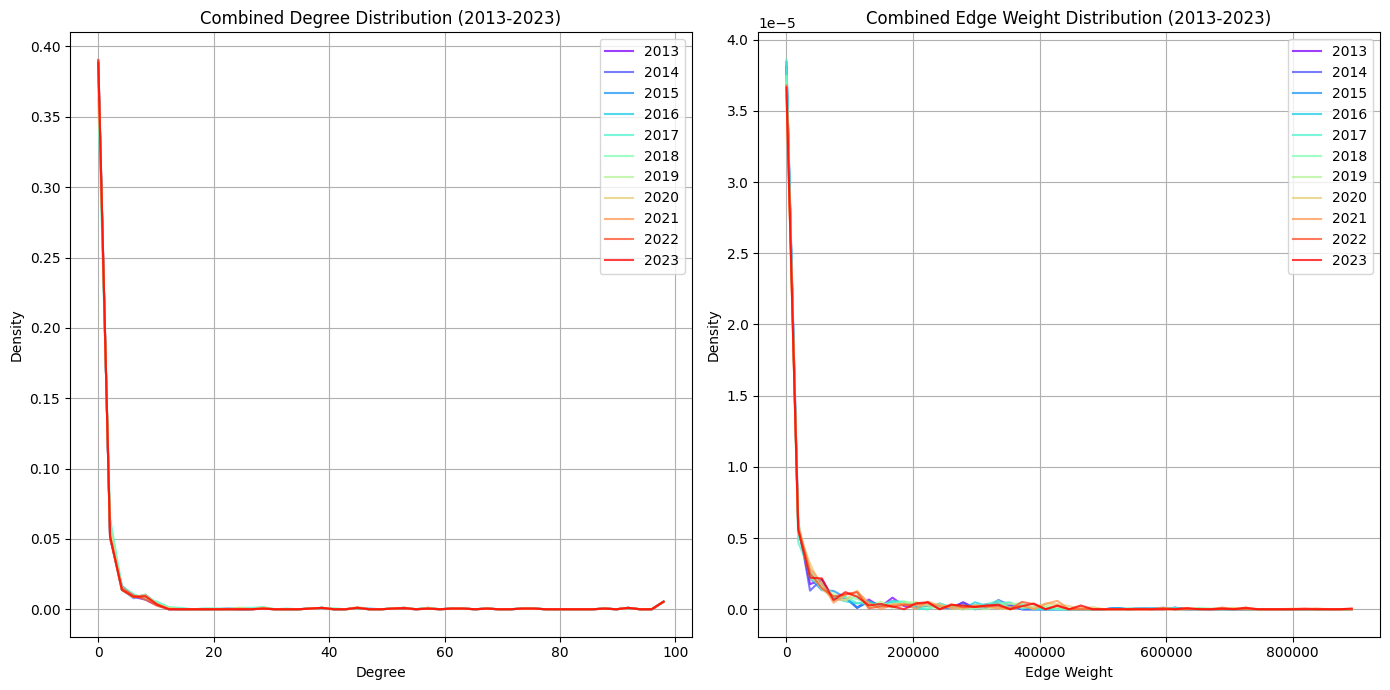

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.cm as cm

csv_file_path_template = 'timeseries_data_{}.csv'
years = range(2013, 2024)

colors = cm.rainbow(np.linspace(0, 1, len(years)))

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)  
max_degree = 0
for year in years:
    df = pd.read_csv(csv_file_path_template.format(year))
    G = nx.from_pandas_edgelist(df, 'ConceptA', 'ConceptB', edge_attr=True)
    degrees = [G.degree(n) for n in G.nodes()]
    max_degree = max(max_degree, max(degrees))
bin_edges = np.linspace(0, max_degree, 50)
for year, color in zip(years, colors):
    df = pd.read_csv(csv_file_path_template.format(year))
    G = nx.from_pandas_edgelist(df, 'ConceptA', 'ConceptB', edge_attr=True)
    degrees = [G.degree(n) for n in G.nodes()]
    hist, _ = np.histogram(degrees, bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], hist, color=color, label=f'{year}', alpha=0.75)
plt.title('Combined Degree Distribution (2013-2023)')
plt.xlabel('Degree')
plt.ylabel('Density')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  
max_weight = 0
for year in years:
    df = pd.read_csv(csv_file_path_template.format(year))
    G = nx.from_pandas_edgelist(df, 'ConceptA', 'ConceptB', edge_attr=True)
    weights = [attr['TotalCount'] for _, _, attr in G.edges(data=True)]
    max_weight = max(max_weight, max(weights))
bin_edges = np.linspace(0, max_weight, 50)
for year, color in zip(years, colors):
    df = pd.read_csv(csv_file_path_template.format(year))
    G = nx.from_pandas_edgelist(df, 'ConceptA', 'ConceptB', edge_attr=True)
    weights = [attr['TotalCount'] for _, _, attr in G.edges(data=True)]
    hist, _ = np.histogram(weights, bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], hist, color=color, label=f'{year}', alpha=0.75)
plt.title('Combined Edge Weight Distribution (2013-2023)')
plt.xlabel('Edge Weight')
plt.ylabel('Density')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Non-Overlapping Community Detection

In [2]:
import pandas as pd
import networkx as nx
from cdlib import algorithms

def load_and_create_graph(file_path):
    data = pd.read_csv(file_path)
    G = nx.Graph()
    for index, row in data.iterrows():
        G.add_edge(row['ConceptA'], row['ConceptB'], weight=row['TotalCount'])
    return G
def detect_communities_and_summarize(G):
    communities = algorithms.louvain(G, weight='weight')
 
    summary = {
        "number_of_communities": len(communities.communities),
        "communities": [sorted(list(community)) for community in communities.communities] 
    }
    return summary

file_paths = {
    '2013': 'timeseries_data_2013.csv',
    '2014': 'timeseries_data_2014.csv',
    '2015': 'timeseries_data_2015.csv',
    '2016': 'timeseries_data_2016.csv',
    '2017': 'timeseries_data_2017.csv',
    '2018': 'timeseries_data_2018.csv',
    '2019': 'timeseries_data_2019.csv',
    '2020': 'timeseries_data_2020.csv',
    '2021': 'timeseries_data_2021.csv',
    '2022': 'timeseries_data_2022.csv',
    '2023': 'timeseries_data_2023.csv',
}

community_summaries = {}
for year, file_path in file_paths.items():
    G = load_and_create_graph(file_path)
    summary = detect_communities_and_summarize(G)
    community_summaries[year] = summary

for year, summary in community_summaries.items():
    print(f"Year: {year}, Number of Communities: {summary['number_of_communities']}")
    for i, community in enumerate(summary['communities'], start=1):
        print(f"  Community {i}: {community}")
    print("\n")


Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}
Year: 2013, Number of Communities: 4
  Community 1: ['.NET Framework', 'Abductive reasoning', 'Abstract data type', 'Abstract interpretation', 'Abstract machine', 'Acceptance testing', 'Accuracy and precision', 'Activity recognition', 'Adaptive algorithm', 'Affective computing', 'Agile software development', 'Algorism', 'Algorithm', 'Algorithm design', 'Analogy', 'Analysis of algorithms', 'Analysis of variance', 'Analytics', 'Anime', 'Anomaly detection', 'Application programming interface', 'Application server', 'Applications of artificial intelligence', 'Applied mathematics', 'Applied probability', 'Applied science', 'A

### Overlapping Community Detection

In [7]:
def detect_communities_with_dcs(G):
    communities = algorithms.dcs(G)
    summary = {
        "number_of_communities": len(communities.communities),
        "communities": [sorted(list(community)) for community in communities.communities] 
    }
    return summary

community_summaries = {}
for year, file_path in file_paths.items():
    G = load_and_create_graph(file_path)
    summary = detect_communities_with_dcs(G)
    community_summaries[year] = summary
    
for year, summary in community_summaries.items():
    print(f"Year: {year}, Number of Communities: {summary['number_of_communities']}")
    for i, community in enumerate(summary['communities'], start=1):
        print(f"  Community {i}: {community}")
    print("\n")

Year: 2013, Number of Communities: 9
  Community 1: ['Acceptance testing', 'Accounting', 'Acoustical engineering', 'Acoustics', 'Actuarial science', 'Aeronautics', 'Aerospace', 'Aerospace engineering', 'Agile software development', 'Agricultural engineering', 'Agricultural science', 'Agronomy', 'Algorithm design', 'Analog computer', 'Anatomy', 'Animal science', 'Anthropology', 'Applied mathematics', 'Applied mechanics', 'Applied physics', 'Applied science', 'Aqueduct', 'Architectural engineering', 'Architecture', 'Arithmetic', 'Art', 'Astronomy', 'Astrophysics', 'Atmospheric sciences', 'Atomic physics', 'Automatic control', 'Automatic programming', 'Automation', 'Automotive engineering', 'Bachelor', 'Behavioral pattern', 'Best practice', 'Biochemical engineering', 'Biochemistry', 'Bioinformatics', 'Biological engineering', 'Biological system', 'Biology', 'Biomechanics', 'Biomedical engineering', 'Biophysics', 'Biotechnology', 'Black box', 'Block diagram', 'Botany', 'Breadboard', 'Build

In [10]:
def detect_communities_with_ipca(G):
    communities = algorithms.ipca(G,weights='weight')
    summary = {
        "number_of_communities": len(communities.communities),
        "communities": [sorted(list(community)) for community in communities.communities] 
    }
    return summary

community_summaries = {}
for year, file_path in file_paths.items():
    G = load_and_create_graph(file_path)
    summary = detect_communities_with_ipca(G)
    community_summaries[year] = summary
    
for year, summary in community_summaries.items():
    print(f"Year: {year}, Number of Communities: {summary['number_of_communities']}")
    for i, community in enumerate(summary['communities'], start=1):
        print(f"  Community {i}: {community}")
    print("\n")

Year: 2013, Number of Communities: 147
  Community 1: ['Algorithm', 'Analytics', 'Application programming interface', 'Application server', 'Associative array', 'Backup', 'Batch processing', 'Bibliography', 'Big data', 'Biometrics', 'Business intelligence', 'COBOL', 'Cache', 'Chart', 'Cloud computing', 'Collaborative software', 'Computer cluster', 'Computer file', 'Computer hardware', 'Computer network', 'Computer science', 'Content management', 'Customer relationship management', 'Data analysis', 'Data integration', 'Data integrity', 'Data management', 'Data migration', 'Data mining', 'Data modeling', 'Data processing', 'Data set', 'Data structure', 'Data validation', 'Data warehouse', 'Database', 'Database administrator', 'Database design', 'Database security', 'Database server', 'Database transaction', 'Datalog', 'Deadlock', 'Digital preservation', 'Digitization', 'Distributed computing', 'Distributed database', 'Document management system', 'End user', 'Enterprise resource planning